In [1]:
%%capture
!pip install mujoco==2.3.3

Ayeen Poostforoushan 401105742

In [2]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


## **Importing Required Libraries**

This cell imports essential libraries for implementing and visualizing Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). The key components include:


In [1]:
from   torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.distributions import Normal
import random
import numpy as np
import logging
import matplotlib
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML
from base64 import b64encode
import gymnasium as gym



is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display



logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

## **Logging, Visualization, and Video Playback Functions**


In [4]:
def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Replay Memory for Experience Replay**

This class implements a **Replay Buffer**, a crucial component in off-policy reinforcement learning algorithms like DDPG and SAC. The buffer stores past experiences and allows the agent to sample them randomly, breaking correlation between consecutive samples and improving learning stability.

In [5]:
class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

## **Neural Networks for DDPG and SAC**

This cell defines key neural networks used in **Deep Deterministic Policy Gradient (DDPG)** and **Soft Actor-Critic (SAC)** algorithms.


- **`GaussianPolicy`**: A stochastic policy for SAC, using Gaussian action sampling.
- **`DeterministicPolicy`**: A deterministic actor for DDPG, applying action bounds.

In [6]:
# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()

        self.q1_input_layer = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.q1_hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.q1_output_layer = nn.Linear(hidden_dim, 1)

        self.q2_input_layer = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.q2_hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.q2_output_layer = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state, action):
        combined = torch.cat([state, action], dim=1)

        q1 = F.relu(self.q1_input_layer(combined))
        q1 = F.relu(self.q1_hidden_layer(q1))
        q1 = self.q1_output_layer(q1)

        q2 = F.relu(self.q2_input_layer(combined))
        q2 = F.relu(self.q2_hidden_layer(q2))
        q2 = self.q2_output_layer(q2)

        return q1, q2


LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space):
        super(GaussianPolicy, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)

        high = action_space.high
        low = action_space.low
        self.action_scale = torch.tensor((high - low)/2, dtype=torch.float32)
        self.action_bias = torch.tensor((high + low)/2, dtype=torch.float32)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()

        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean




class DeterministicPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(DeterministicPolicy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, num_actions)
        self.noise = torch.Tensor(num_actions)

        self.apply(weights_init_)

        # Compute scaling/shifting parameters
        high = action_space.high
        low = action_space.low
        self.action_bias = torch.tensor((high + low)/2, dtype=torch.float32)
        self.action_scale = torch.tensor((high - low)/2, dtype=torch.float32)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = torch.tanh(self.mean(x)) * self.action_scale + self.action_bias
        return mean

    def sample(self, state):
        mean = self.forward(state)
        noice = self.noise.normal_(0.0, std=0.1)
        action = mean + noice
        action = torch.clamp(action, self.action_bias - self.action_scale, self.action_bias + self.action_scale)
        return action, torch.tensor(0.0), mean


## **Soft Actor-Critic (SAC) Implementation - Explanation of the Cell**

This cell implements the **Soft Actor-Critic (SAC) algorithm**, a state-of-the-art off-policy reinforcement learning method for continuous control. The key idea behind SAC is to maximize both the **expected reward** and the **entropy** of the policy, promoting exploration and robustness.

### **Main Components in This Cell**
1. **Hyperparameters & Configuration**  
   - The algorithm's key parameters such as **discount factor** ($\gamma$), **soft update factor** ($\tau$), and **entropy coefficient** ($\alpha$) are set from the `config` dictionary.
   - **Entropy tuning** is optionally enabled to adjust $\alpha$ dynamically.

2. **Critic (Q-Networks)**
   - Two separate **Q-networks** (`self.critic` and `self.critic_target`) estimate the action-value function.
   - Using **twin Q-learning** (two critics) reduces overestimation bias.

3. **Actor (Policy Network)**
   - **Gaussian policy** is used when `policy_type="Gaussian"`, meaning actions are sampled from a probability distribution instead of being deterministic.
   - The policy is trained to maximize both expected rewards and entropy.
   - If the deterministic version (DDPG-like) is used, entropy is ignored ($\alpha = 0$).

4. **Action Selection (`select_action`)**
   - If `evaluate=False`, actions are sampled from the stochastic policy.
   - If `evaluate=True`, deterministic actions are chosen for testing.

5. **Parameter Update (`update_parameters`)**
   - **Sample a batch** from replay memory.
   - Compute **target Q-values** using the **minimum of the two Q-networks**.
   - Update **critic networks** by minimizing Bellman loss.
   - Update **policy** using the entropy-regularized objective.
   - If entropy tuning is enabled, update **$\alpha$** using.
   - Periodically **soft update** the target Q-network.


In [7]:
class SAC(object):
    def __init__(self, num_inputs, action_space, config):

        self.gamma = config['gamma']
        self.tau = config['tau']
        self.alpha = config['alpha']

        self.policy_type = config["policy"]
        self.target_update_interval = config["target_update_interval"]
        self.automatic_entropy_tuning = config['automatic_entropy_tuning']

        self.device = torch.device("cuda" if config['cuda'] else "cpu")

        self.critic = QNetwork(num_inputs, action_space.shape[0], config['hidden_size']).to(device=self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=config['lr'])

        self.critic_target = QNetwork(num_inputs, action_space.shape[0], config["hidden_size"]).to(self.device)
        self.hard_update(self.critic_target, self.critic)

        if self.policy_type == "Gaussian":
            self.target_entropy = -np.prod(action_space.shape).item()
            self.log_alpha = torch.zeros(1, device=self.device, requires_grad=True)
            self.alpha_optim = Adam([self.log_alpha], lr=config['lr'])

            self.policy = GaussianPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=config["lr"])

        else:
            self.alpha = 0
            self.automatic_entropy_tuning = False
            self.policy = DeterministicPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=config['lr'])

    def select_action(self, state, evaluate=False):
        state = torch.as_tensor(state, dtype=torch.float32, device=self.device)[None]
        if not evaluate:
            action = self.policy.sample(state)[0]
        else:
            action = self.policy.sample(state)[2]
        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size, updates):
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * (min_qf_next_target)

        current_q1, current_q2 = self.critic(state_batch, action_batch)
        q1_diff = current_q1 - next_q_value
        q2_diff = current_q2 - next_q_value
        q1_loss = 0.5 * (q1_diff.pow(2)).mean()
        q2_loss = 0.5 * (q2_diff.pow(2)).mean()
        qf_loss = q1_loss + q2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)

        # with torch.no_grad():
        q_pi1, q_pi2 = self.critic(state_batch, pi)
        min_q_pi = torch.minimum(q_pi1, q_pi2)
        policy_loss = (self.alpha * log_pi - min_q_pi).mean()

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()

        if self.automatic_entropy_tuning:
            alpha_logs = self.log_alpha.expand_as(log_pi)
            alpha_loss = (-alpha_logs * (log_pi.detach() + self.target_entropy)).mean()

            self.alpha_optim.zero_grad(set_to_none=True)
            alpha_loss.backward()
            self.alpha_optim.step()
            self.alpha = self.log_alpha.detach().exp()
            alpha_tlogs = self.alpha.clone()
        else:
            alpha_loss = torch.zeros(1, device=self.device)
            alpha_tlogs = torch.tensor(self.alpha)

        if updates % self.target_update_interval == 0:
            self.soft_update(self.critic_target, self.critic, self.tau)

        return q1_loss.item(), q2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_tlogs.item()

    def soft_update(self, target, source, tau):
        with torch.no_grad():
            for t, s in zip(target.parameters(), source.parameters()):
                t.data.mul_(1.0 - tau)
                t.data.add_(s.data * tau)

    def hard_update(self,target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

## **Environment Setup and Initialization for SAC**

This cell sets up the environment and initializes the components needed to train the **Soft Actor-Critic (SAC)** agent.


In [8]:
# Configuration dictionary
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Gaussian",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": 0.2,
    "seed":123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": False,
    "eval_interval": 1,
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])




## **Training Loop for SAC Agent**

This cell contains the **training loop** for the Soft Actor-Critic (SAC) agent. The loop runs for a set number of episodes, where in each episode, the agent interacts with the environment, collects experiences, and updates its parameters.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode: 0, train_reward: -258.04560416101316, eval_reward: 0, avg_train_reward: -258.04560416101316
Episode: 10, train_reward: -179.48250432317147, eval_reward: -219.50055083710743, avg_train_reward: -256.05485821492005
Episode: 20, train_reward: 18.33275592420621, eval_reward: 588.3189180197936, avg_train_reward: -124.51213404015793
Episode: 30, train_reward: 149.84976287631713, eval_reward: 1147.4372206248663, avg_train_reward: 166.50535925891523
Episode: 40, train_reward: 1436.4686203314918, eval_reward: 2205.257975674986, avg_train_reward: 843.8410276942656
Episode: 50, train_reward: 151.7339872809393, eval_reward: 2391.095354932367, avg_train_reward: 1175.920624803765
Episode: 60, train_reward: 2734.722572444003, eval_reward: 3211.7104702588113, avg_train_reward: 1528.602646975592
Episode: 70, train_reward: 3053.4096265659805, eval_reward: 3546.1180422396933, avg_train_reward: 2800.221538885392
Episode: 80, train_reward: 3201.9917485096025, eval_reward: 4134.664760261276, avg_tra

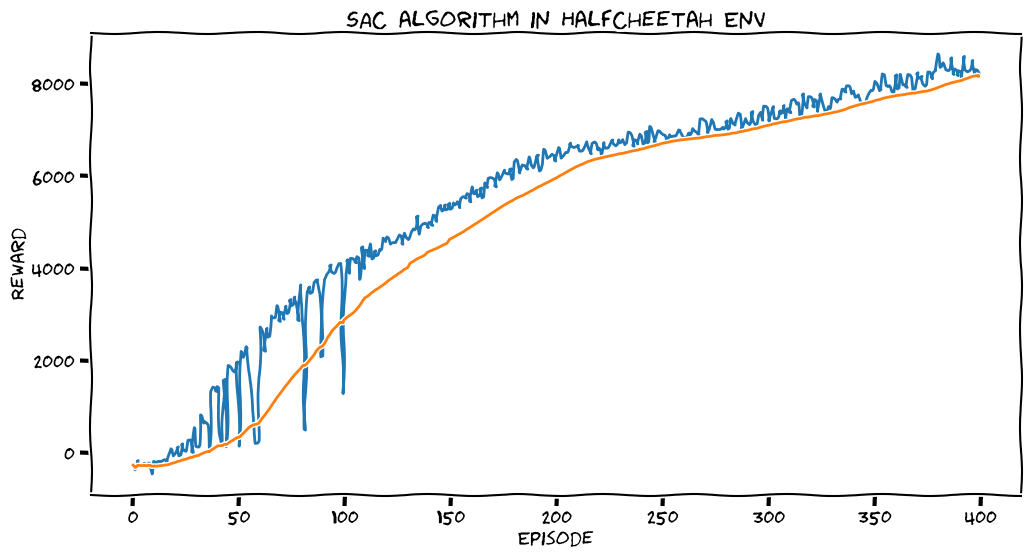

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [9]:
# Training Loop
total_numsteps = 0
updates = 0
reward_history = []
avg_train_reward = 0
Max_episodes = 400
criteria = 0
max_reward = -1000
for i_episode in range(Max_episodes):
    episode_steps = 0
    episode_rewards = 0
    done = False
    state, _ = env.reset()

    while not done:
        if config['start_steps'] > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(state)  # Sample action from policy

        if len(memory) > config['batch_size']:
              critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, config['batch_size'], updates)
              updates += 1

        next_state, reward, done, truncated, _ = env.step(action) # Step
        episode_rewards += reward
        episode_steps += 1
        total_numsteps +=1
        done = done or truncated

        # Ignore the "done" signal if it comes from hitting the time horizon.

        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask) # Append transition to memory

        state = next_state

    reward_history.append(episode_rewards)

    # TODO 14: Evaluate the policy at regular intervals and log the average reward.
    ev_episode_reward = 0
    # TODO 14: Here, we are running evaluation episodes to measure how well the policy is performing over time.
    if i_episode % config['eval_interval'] == 0 and i_episode > 0:
        ev_state, _ = env.reset()
        ev_episode_reward = 0
        while True:
            ev_action = agent.select_action(ev_state, evaluate=True)
            ev_next_state, ev_reward, done, truncated, _ = env.step(ev_action)
            ev_episode_reward += ev_reward
            done = done or truncated
            if done:
                break
            ev_state = ev_next_state


    avg_train_reward = np.mean(reward_history[-10:])

    if i_episode % 10 == 0:
        print("Episode: {}, train_reward: {}, eval_reward: {}, avg_train_reward: {}".format(i_episode, episode_rewards, ev_episode_reward, avg_train_reward))

    # if avg_reward < max_reward:
    #     criteria +=1
    #     if criteria == 50:
    #         break
    #     else:
    #         criteria = 0

    # max_reward = max(reward_history)

env.close()


plot_rewards(reward_history, show_result='SAC algorithm in HalfCheetah Env')

## Unfortunately I forgot to put `state = next_state` so this block is not showing the real performance of the agent.
## I lost my variables and I didn't have time to run the code again.
## But you can see that the evaluation of the model in the training phase also had ~8000 reward.

In [10]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []
done = False

total_reward = 0
# run the policy in the environment in a loop
while not done:
    frames.append(env.render())
    action  = agent.select_action(state, evaluate=True)
    next_state, reward, done, truncated, _  = env.step(action)
    total_reward += reward

    done = done or truncated

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_SAC.mp4', frames, fps=25)
show_video('./eval_SAC.mp4')

Total Reward: -326.4896644828485


# **Initialize DDPG**

In [11]:
# Configuration dictionary
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Deterministic",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": 0.2,
    "seed":123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": False,
    "eval_interval": 1,
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])

# **Train the DDPG here**

Episode: 0, train_reward: -432.72218315338955, eval_reward: 0
Episode: 10, train_reward: -576.427090450336, eval_reward: -399.67473185394846
Episode: 20, train_reward: -50.87127381886657, eval_reward: 25.825130802248914
Episode: 30, train_reward: -166.36765542427437, eval_reward: 251.37405446020108
Episode: 40, train_reward: 339.6836532396066, eval_reward: 2011.3186332319115
Episode: 50, train_reward: 2522.6158119854017, eval_reward: 2426.052081350796
Episode: 60, train_reward: 2939.1561377810017, eval_reward: 2801.1383330603176
Episode: 70, train_reward: 3484.6740925962054, eval_reward: 3525.189558179337
Episode: 80, train_reward: 3432.9042874428, eval_reward: 3545.047466954182
Episode: 90, train_reward: 4081.3016482887624, eval_reward: 3922.163657370573
Episode: 100, train_reward: 4188.332610262051, eval_reward: 4457.462974761063
Episode: 110, train_reward: 4498.191834301397, eval_reward: 4252.729388011796
Episode: 120, train_reward: 4712.737279153192, eval_reward: 4990.539650091013


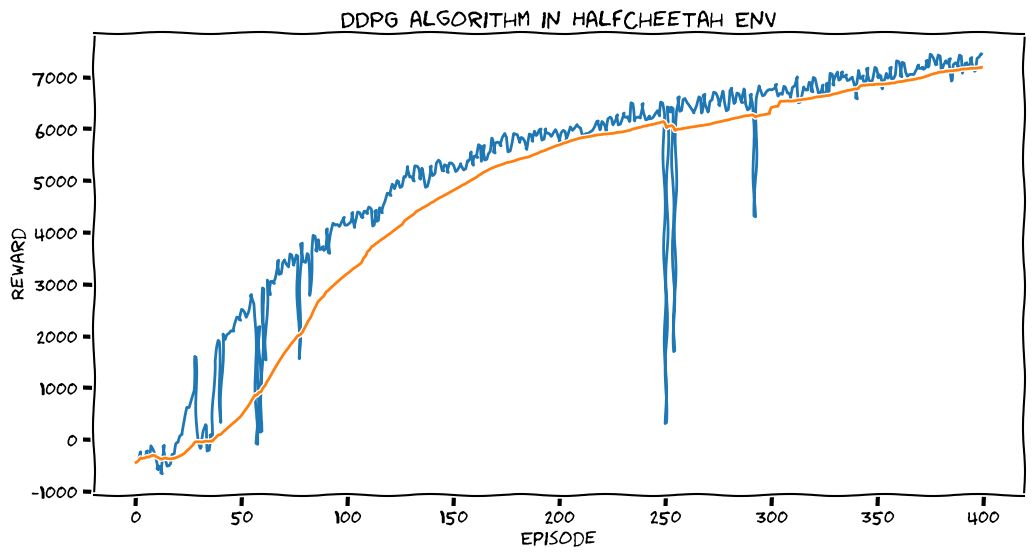

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [12]:
# Training Loop
total_numsteps = 0
updates = 0
reward_history = []
Max_episodes = 400
criteria = 0
max_reward = -3000
for i_episode in range(Max_episodes):
    episode_steps = 0
    episode_reward = 0
    done = False
    state, _ = env.reset()

    while not done:
        if config['start_steps'] > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(state)  # Sample action from policy

        if len(memory) > config['batch_size']:
            agent.update_parameters(memory, config['batch_size'], updates)
            updates += 1

        next_state, reward, done, truncated, _ = env.step(action) # Step
        episode_steps += 1
        total_numsteps +=1
        episode_reward += reward
        done = done or truncated

        # Ignore the "done" signal if it comes from hitting the time horizon.

        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask) # Append transition to memory

        state = next_state

    reward_history.append(episode_reward)

    if i_episode % config['eval_interval'] == 0 and i_episode > 0:
        ev_state, _ = env.reset()
        ev_episode_reward = 0
        while True:
            ev_action = agent.select_action(ev_state, evaluate=True)
            ev_next_state, ev_reward, done, truncated, _ = env.step(ev_action)
            ev_episode_reward += ev_reward
            done = done or truncated
            if done:
                break
            ev_state = ev_next_state
    else:
        ev_episode_reward = 0

    if i_episode % 10 == 0:
        print("Episode: {}, train_reward: {}, eval_reward: {}".format(i_episode, episode_reward, ev_episode_reward))

env.close()

plot_rewards(reward_history, show_result='DDPG algorithm in HalfCheetah Env')

## Unfortunately I forgot to put `state = next_state` so this block is not showing the real performance of the agent.
## I lost my variables and I didn't have time to run the code again.
## But you can see that the evaluation of the model in the training phase also had ~7000 reward.

In [13]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []
done = False

total_reward = 0
# run the policy in the environment in a loop
while not done:
    frames.append(env.render())
    action  = agent.select_action(state, evaluate=True)
    next_state, reward, done, truncated, _  = env.step(action)
    total_reward += reward

    done = done or truncated

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_DDPG.mp4', frames, fps=25)
show_video('./eval_DDPG.mp4')

Total Reward: -385.9758048455075
